<a href="https://colab.research.google.com/github/dextopman/pytorch-tutorial/blob/master/AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from imageio import imread
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

<ipython-input-19-79d83d8ca931>:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [20]:
alexnet = torchvision.models.alexnet(pretrained=True)

for p in alexnet.parameters():
  p.requires_grad = False

alexnet.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

alexnet.to(device);

In [22]:
device

device(type='cuda')

In [23]:
img4content = imread('https://static9.depositphotos.com/1012104/1096/i/950/depositphotos_10962994-stock-photo-spinosaurus.jpg')
img4style = imread('https://www.christies.com/img/LotImages/2015/NYR/2015_NYR_03739_0008A_000(pablo_picasso_les_femmes_dalger).jpg')

img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

<ipython-input-23-6ef9ca3f6ebf>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4content = imread('https://static9.depositphotos.com/1012104/1096/i/950/depositphotos_10962994-stock-photo-spinosaurus.jpg')


(754, 1023, 3)
(754, 1023, 3)
(2599, 3200, 3)


<ipython-input-23-6ef9ca3f6ebf>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img4style = imread('https://www.christies.com/img/LotImages/2015/NYR/2015_NYR_03739_0008A_000(pablo_picasso_les_femmes_dalger).jpg')


In [24]:
Ts = T.Compose([T.ToTensor(),
                #T.ToPILImage(),
                T.Resize(256),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                ])
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style ).unsqueeze(0).to(device)
img4target  = Ts( img4target ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 347])
torch.Size([1, 3, 256, 347])
torch.Size([1, 3, 256, 315])


Text(0.5, 1.0, 'Style picture')

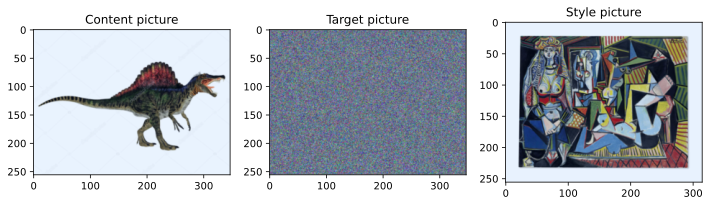

In [25]:
fig,ax = plt.subplots(1,3,figsize=(12,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

In [26]:
def getFeatureMapActs(img,net):
  featuremaps = []
  featurenames = []

  convLayerIdx = 0

  for layernum in range(len(net.features)):

    img = net.features[layernum](img)

    if 'Conv2d' in str(net.features[layernum]):
      featuremaps.append(img)
      featurenames.append(f'ConvLayer_{convLayerIdx}')
      convLayerIdx += 1

  return featuremaps,featurenames

In [27]:
def gram_matrix(F):
  _,chns,height,width = F.shape
  F = F.reshape(chns,height*width)

  gram = torch.mm(F,F.t()) / (chns*height*width)
  return gram

In [28]:
featmaps,featnames = getFeatureMapActs(img4content,alexnet)

for i in range(len(featnames)):
  print('Feature map "%s" is size %s'%(featnames[i],(featmaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 63, 86])
Feature map "ConvLayer_1" is size torch.Size([1, 192, 31, 42])
Feature map "ConvLayer_2" is size torch.Size([1, 384, 15, 20])
Feature map "ConvLayer_3" is size torch.Size([1, 256, 15, 20])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 15, 20])


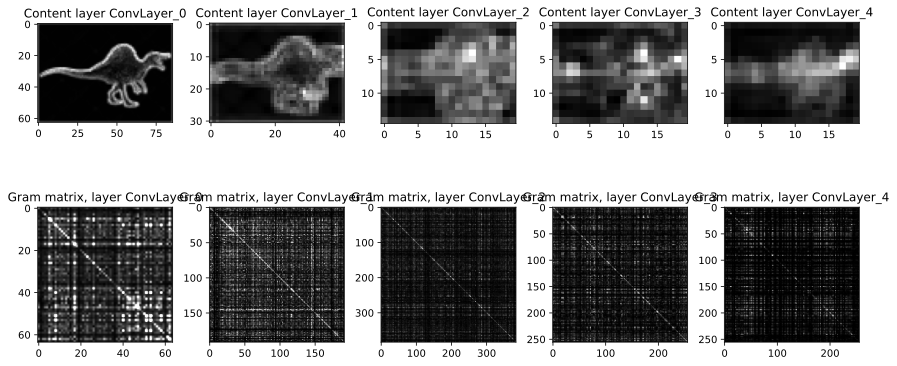

In [29]:
contentFeatureMaps,contentFeatureNames = getFeatureMapActs(img4content,alexnet)

fig,axs = plt.subplots(2,5,figsize=(12,6))
for i in range(5):
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title('Content layer ' + str(contentFeatureNames[i]))

  pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(contentFeatureNames[i]))

plt.tight_layout()
plt.show()

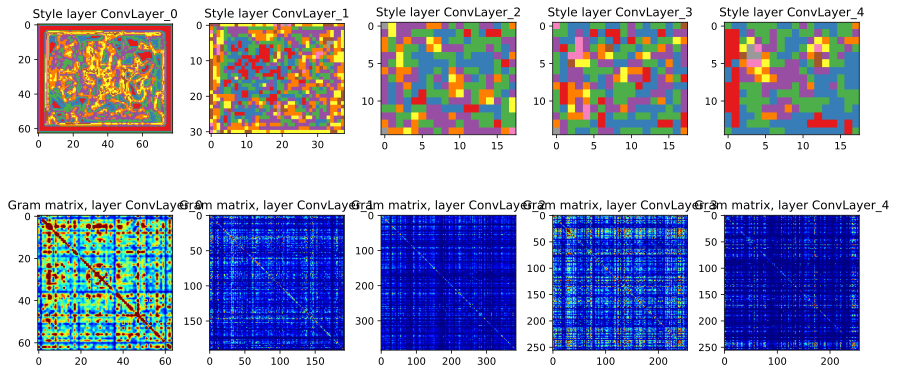

In [30]:
styleFeatureMaps,styleFeatureNames = getFeatureMapActs(img4style,alexnet)

fig,axs = plt.subplots(2,5,figsize=(12,6))

for i in range(5):
  pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='Set1')
  axs[0,i].set_title('Style layer ' + str(styleFeatureNames[i]))

  pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='jet',vmax=.1)
  axs[1,i].set_title('Gram matrix, layer ' + str(styleFeatureNames[i]))

plt.tight_layout()
plt.show()

In [31]:
layers4content = [ 'ConvLayer_0']
layers4style   = [ 'ConvLayer_0','ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4' ]
weights4style  = [      1       ,      .8      ,     .6      ,    .4      ,      .2      ]

In [32]:
target = img4content.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 5e4

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.001)


for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = getFeatureMapActs(target,alexnet)


  # initialize the individual loss components
  styleLoss = torch.tensor(0.0, requires_grad=True).to(device)
  contentLoss = torch.tensor(0.0, requires_grad=True).to(device)

  # loop over layers
  for layeri in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layeri] in layers4content:
      contentLoss = contentLoss + torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 )


    # compute the style loss
    if targetFeatureNames[layeri] in layers4style:

      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(styleFeatureMaps[layeri])

      # compute their loss (de-weighted with increasing depth)

      styleLoss = styleLoss + torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]


  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()


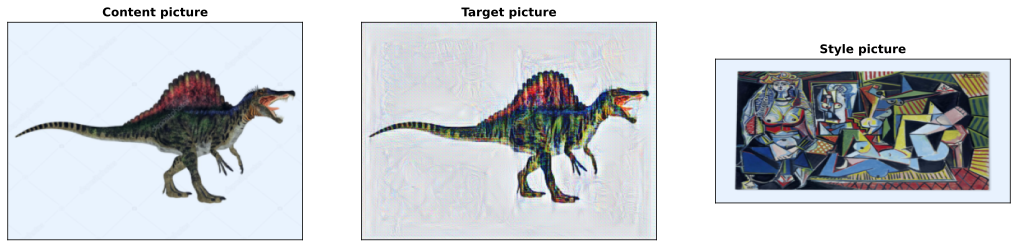

In [33]:
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()